After first implementation it looks like it's somehow broken - either formulas, or the code, or... both or something else.
Let's check it in more depth, but this time without using random sound, let's generate sound, that should give us well known results.

First, let's start from a simple sine wave.

In [1]:
import numpy as np
from scipy.io import wavfile

sample_rate = 44100
frequency = 440
length = 1

t = np.linspace(0, length, sample_rate * length)
y = np.sin(frequency * 2 * np.pi * t)
    
simple_sine_wave_440Hz = y

In [2]:
frame_rate = 25.0 # framerate of a video
current_time = 0.0 # in seconds
current_frame = int(current_time * frame_rate)
number_of_frames = 1
sample_start = int((current_frame) / frame_rate * sample_rate)
sample_end = int((current_frame + number_of_frames) / frame_rate * sample_rate)
number_of_samples = sample_end-sample_start
audio_part = simple_sine_wave_440Hz[sample_start:sample_end]
n_fft = int(number_of_samples)

First, waveform:

In [3]:
from PIL import Image

def array_to_red_image(array):
    img = None
    # grey image from array
    img = Image.fromarray(array, mode='L')
    # empty grey image
    zero = np.zeros(array.shape, dtype=np.uint8)
    img_zero = Image.fromarray(zero, mode='L')
    # merge it. Real image goes to R channel, while G and B channels filled with zeroes
    img = Image.merge(mode='RGB', bands=(img, img_zero, img_zero))
    return img

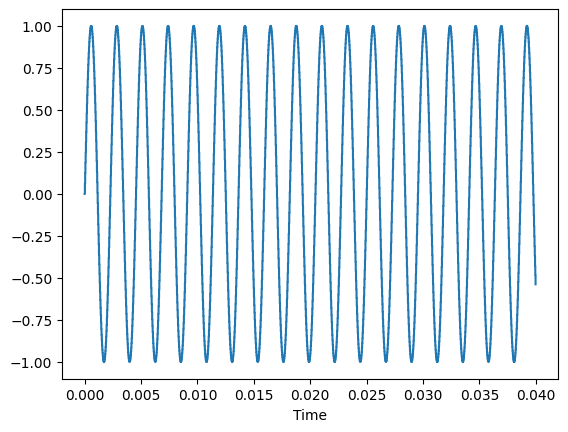

In [4]:
from librosa.display import waveshow
import matplotlib.pyplot as plt

waveplot = waveshow(audio_part, sr=sample_rate)
plt.show()

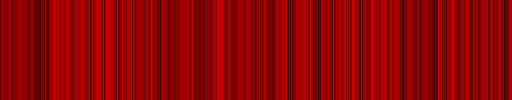

In [5]:
from skimage import exposure

audio_part_img = exposure.rescale_intensity(audio_part, out_range=(-1.0, 1.0))
audio_wave_img = array_to_red_image(audio_part_img)
audio_wave_img = audio_wave_img.rotate(-90, expand=True)
audio_wave_img = audio_wave_img.resize((512,100))
display(audio_wave_img)

Now, frequency spectrogram.
However, this time we will do it using a linear freqs scale (x-axis), as it looks like that's how ShaderToy has implemented it (why??).

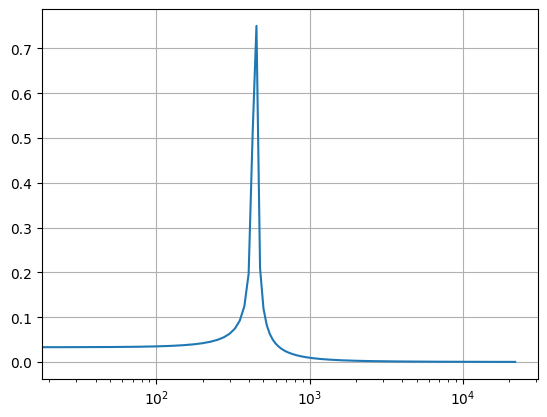

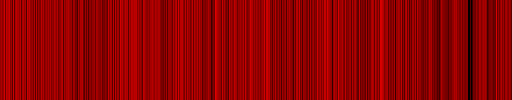

In [6]:
from scipy.fft import fft, fftfreq

yf = fft(audio_part)
xf = fftfreq(number_of_samples, 1.0/sample_rate)[:number_of_samples//2]

plt.plot(xf, 2.0/number_of_samples * np.abs(yf[0:number_of_samples//2]))
plt.xscale('log')
plt.grid()
plt.show()

yfs = exposure.rescale_intensity(yf.real, out_range=(0.0, 1.0))
fft_img = array_to_red_image(yfs)
fft_img = fft_img.rotate(-90, expand=True)
fft_img = fft_img.resize((512,100))
display(fft_img)

It looks like my previous method of tranforming data from NDArray into an image doesn't play so well with that data :/
Let's try some more standard way of doing it...

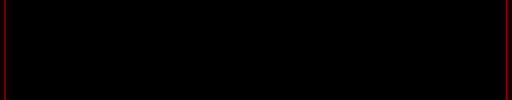

In [7]:
yf = fft(audio_part)
xf = fftfreq(number_of_samples, 1.0/sample_rate)[:number_of_samples//2]
# get rid of imaginary data
yfr = yf.real
# get absolute values
yfrabs = abs(yfr)
# get max value
max = np.max(yfrabs)
# normalize to 0.0 - 1.0 range
yfuint8 = yfrabs.astype(np.float64) / max
# make it uint8 data
yfuint8 = 255 * yfuint8
yfuint8_img = yfuint8.astype(np.uint8)
# now we can convert it to an image...
fft_img = array_to_red_image(yfuint8_img)
fft_img = fft_img.rotate(-90, expand=True)
fft_img = fft_img.resize((512,100))
display(fft_img)

Try the same method on a wave plot:

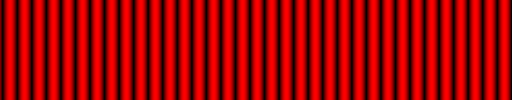

In [8]:
yfr = audio_part.real
# get absolute values
yfrabs = abs(yfr)
# get max value
max = np.max(yfrabs)
# normalize to 0.0 - 1.0 range
yfuint8 = yfrabs.astype(np.float64) / max
# make it uint8 data
yfuint8 = 255 * yfuint8
yfuint8_img = yfuint8.astype(np.uint8)
# now we can convert it to an image...
wave_img = array_to_red_image(yfuint8_img)
wave_img = wave_img.rotate(-90, expand=True)
wave_img = wave_img.resize((512,100))
display(wave_img)

Perfect!
Let's summarize it in one function, and then try it out on a sine frequency sweep:

In [9]:
def array_to_red_image(array):
    img = None
    # get rid of imaginary data
    array = array.real
    # get absolute values
    array = abs(array)
    # get max value
    max = np.max(array)
    # normalize to 0.0 - 1.0 range
    arrayuint8 = array.astype(np.float64) / max
    # make it uint8 data
    arrayuint8 = 255 * arrayuint8
    # grey image from array
    img = Image.fromarray(arrayuint8.astype(np.uint8), mode='L')
    # empty grey image
    zero = np.zeros(array.shape, dtype=np.uint8)
    img_zero = Image.fromarray(zero, mode='L')
    # merge it. Real image goes to R channel, while G and B channels filled with zeroes
    img = Image.merge(mode='RGB', bands=(img, img_zero, img_zero))
    return img

In [24]:
import numpy as np
from scipy import signal
from scipy.io import wavfile

sampleRate = 44100
frequency_start = 1000
frequency_end = 8000
length = 2

t = np.linspace(0, length, sampleRate * length)
y = signal.chirp(t, f0=frequency_start, f1=frequency_end, t1=length)

m = np.max(np.abs(y))
maxint16 = np.iinfo(np.int16).max
y = maxint16 * y / m
y = y.astype(np.int16) 

freq_sweep_sine = y

In [25]:
frame_rate = 25.0 # framerate of a video
current_time = 0.0 # in seconds
current_frame = int(current_time * frame_rate)
number_of_frames = 1
sample_start = int((current_frame) / frame_rate * sample_rate)
sample_end = int((current_frame + number_of_frames) / frame_rate * sample_rate)
number_of_samples = sample_end-sample_start
audio_part = freq_sweep_sine[sample_start:sample_end]
n_fft = int(number_of_samples)

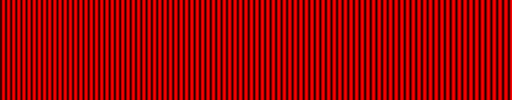

In [26]:
waveplot_img = array_to_red_image(audio_part)
waveplot_img = waveplot_img.rotate(-90, expand=True)
waveplot_img = waveplot_img.resize((512,100))
display(waveplot_img)

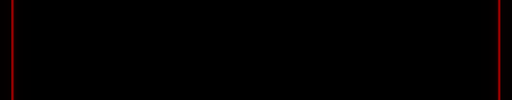

In [27]:
fft_img = array_to_red_image(fft(audio_part))
fft_img = fft_img.rotate(-90, expand=True)
fft_img = fft_img.resize((512,100))
display(fft_img)

Ok, one more thing: we're clearly seing the imaginary part of sepctrum (or mirrored real).
Let's calculate FFT only for a real values of a signal.
Also, we will apply a Hann window to smooth values and deal with the beginning and ending of a sampled signal.

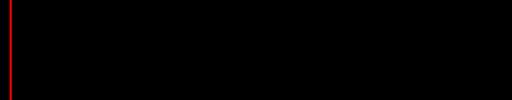

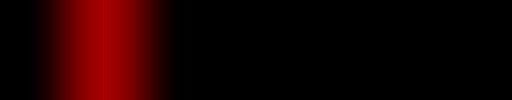

In [57]:
from scipy.fft import rfft
from scipy.signal.windows import hann

signal = simple_sine_wave_440Hz[0:1024]
N = signal.shape[0]
w = hann(N)
c_w = abs(sum(w))
fft_filtered = rfft(signal * w) / c_w 
fftdb_img = array_to_red_image(fft_filtered)
fftdb_img = fftdb_img.rotate(90, expand=True)
fftdb_img = fftdb_img.resize((512,100))
display(fftdb_img)

signal = freq_sweep_sine
N = signal.shape[0]
w = hann(N)
c_w = abs(sum(w))
fft_filtered = rfft(signal * w) / c_w 
fftdb_img = array_to_red_image(fft_filtered)
fftdb_img = fftdb_img.rotate(90, expand=True)
fftdb_img = fftdb_img.resize((512,100))
display(fftdb_img)

In [ ]:
How about rescaling values to dB?

Number of values in simple FFT: 513
Number of values in filtered FFT: 513
Number of values in reduced FFT: 256


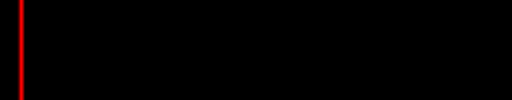

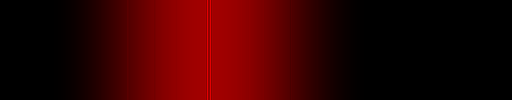

In [67]:
signal = simple_sine_wave_440Hz[0:1024]
simple_fft = rfft(signal)
N = signal.shape[0]
w = hann(N)
c_w = abs(sum(w))
fft_filtered = rfft(signal * w) / c_w

print(f'Number of values in simple FFT: {simple_fft.shape[0]}')
print(f'Number of values in filtered FFT: {fft_filtered.shape[0]}')

reduced_N = int(fft_filtered.shape[0]/2)
reduced_fft = fft_filtered[0:reduced_N]
print(f'Number of values in reduced FFT: {reduced_fft.shape[0]}')

fftdb_img = array_to_red_image(reduced_fft)
fftdb_img = fftdb_img.rotate(90, expand=True)
fftdb_img = fftdb_img.resize((512,100))
display(fftdb_img)


signal = freq_sweep_sine
N = signal.shape[0]
w = hann(N)
c_w = abs(sum(w))
fft_filtered = rfft(signal * w) / c_w 
reduced_N = int(fft_filtered.shape[0]/2)
reduced_fft = fft_filtered[0:reduced_N]

fftdb_img = array_to_red_image(reduced_fft)
fftdb_img = fftdb_img.rotate(90, expand=True)
fftdb_img = fftdb_img.resize((512,100))
display(fftdb_img)

And now some real music file.

In [60]:
import librosa
audio, sample_rate = librosa.load('test_sound_01.mp3', mono=True, sr=None)
num_samples = audio.shape[0]
duration = num_samples / sample_rate

In [61]:
frame_rate = 30.0 # framerate of a video
current_time = 30.0 # in seconds

position = current_time
current_frame = int(position*frame_rate)
samples_per_frame = int(sample_rate / frame_rate)
sample_start = int(position * sample_rate)
sample_end = sample_start + samples_per_frame
N = sample_end - sample_start
T = 1.0 / sample_rate
audio_part = audio[sample_start:sample_end]

n_fft = int(N)

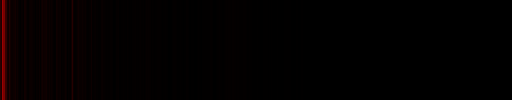

In [62]:
signal = audio_part
w = hann(N)
c_w = abs(sum(w))
fft_filtered = rfft(audio_part * w) / c_w 
fftdb_img = array_to_red_image(fft_filtered)
fftdb_img = fftdb_img.rotate(90, expand=True)
fftdb_img = fftdb_img.resize((512,100))
display(fftdb_img)